In [18]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# ======================================================
# 1. HÀM METRIC DÙNG CHUNG
# ======================================================

def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_metric(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

def wape_metric(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return np.nan
    return np.sum(np.abs(y_true - y_pred)) / denom

def safe_r2(y_true, y_pred):
    y_true = np.asarray(y_true)
    if np.var(y_true) == 0:
        return 0.0
    return r2_score(y_true, y_pred)

def make_ohe_dense():
    """Tạo OneHotEncoder trả về dense, chạy được nhiều version sklearn."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# ======================================================
# 2. ĐỌC MASTER train_data.csv & CHUẨN BỊ FEATURE GLOBAL
# ======================================================

df_all = (
    pd.read_csv("train_data.csv", parse_dates=["date"])
      .sort_values("date")
      .reset_index(drop=True)
)

id_cols = ["date", "store_nbr", "family"]
y_col = "sales"

missing = [c for c in id_cols + [y_col] if c not in df_all.columns]
if missing:
    raise ValueError(f"Missing required columns in train_data.csv: {missing}")

X_cols = [c for c in df_all.columns if c not in id_cols + [y_col]]
X_all = df_all[X_cols]
y_all = df_all[y_col]

num_cols = X_all.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X_all.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Global model – numeric features: {len(num_cols)}, categorical features: {len(cat_cols)}")

# ======================================================
# 3. ĐỌC family_segments.csv → segment High / Medium / ...
# ======================================================

seg_raw = pd.read_csv("family_segments.csv")
seg = seg_raw.copy()
seg.columns = [c.strip().lower() for c in seg.columns]

rename_map = {}
for c in seg.columns:
    if "family" in c and c != "family":
        rename_map[c] = "family"
    if "segment" in c and c != "segment":
        rename_map[c] = "segment"
seg = seg.rename(columns=rename_map)

if "family" not in seg.columns or "segment" not in seg.columns:
    raise ValueError("family_segments.csv cần có cột 'family' và 'segment' (sau chuẩn hoá).")

seg = seg[["family", "segment"]]
seg_mapping = dict(zip(seg["family"], seg["segment"]))

# ======================================================
# 4. PIPELINE LINEAR REGRESSION GLOBAL (GIỐNG PHASE 2)
# ======================================================

preproc_lr = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", make_ohe_dense()),
        ]), cat_cols),
    ],
    remainder="drop"
)

lr_pipe = Pipeline([
    ("pre", preproc_lr),
    ("model", LinearRegression())
])

# ======================================================
# 5. 5 FOLDS time-series: train_fold_i.csv / test_fold_i.csv
#    → Lấy OOF cho segment High + Medium
# ======================================================

fold_paths = [(f"train_fold_{i}.csv", f"test_fold_{i}.csv") for i in range(1, 6)]

def ensure_schema(df_fold: pd.DataFrame) -> pd.DataFrame:
    """Đảm bảo mỗi fold có đủ các cột X_cols theo train_data.csv."""
    cols_present = set(df_fold.columns)
    need = [c for c in X_cols if c not in cols_present]
    for c in need:
        df_fold[c] = np.nan
    return df_fold[id_cols + [y_col] + X_cols]

def build_lr_oof_for_segments(pipe_template, fold_paths, segments=("High", "Medium")):
    """
    Chạy LR 5-fold như Phase 2, nhưng chỉ giữ OOF cho các family thuộc segment H/M.
    Train trên full train_fold (mọi segment), filter theo segment ở test.
    """
    oof_parts = []
    for fold_id, (tr_path, te_path) in enumerate(fold_paths, start=1):
        tr = pd.read_csv(tr_path, parse_dates=["date"]).sort_values("date")
        te = pd.read_csv(te_path, parse_dates=["date"]).sort_values("date")

        tr = ensure_schema(tr)
        te = ensure_schema(te)

        # train trên toàn bộ training fold
        X_tr, y_tr = tr[X_cols], tr[y_col]
        pipe = clone(pipe_template)
        pipe.fit(X_tr, y_tr)

        # gắn segment cho test, rồi lọc theo segments mong muốn
        te_seg = te.merge(seg, on="family", how="left")
        mask = te_seg["segment"].isin(segments)
        if not mask.any():
            print(f"Fold {fold_id}: không có family thuộc segments={segments}")
            continue

        te_sub = te_seg.loc[mask].copy()
        X_te, y_te = te_sub[X_cols], te_sub[y_col]

        ids = te_sub[id_cols].copy()
        y_pred = pipe.predict(X_te)

        part = ids.copy()
        part["y_true"] = y_te.to_numpy()
        part["y_pred"] = y_pred
        part["fold"] = fold_id
        part["segment"] = te_sub["segment"].to_numpy()

        oof_parts.append(part)

        print(f"Fold {fold_id}: kept {mask.sum()} rows for segments {segments}")

    if not oof_parts:
        raise RuntimeError("Không có bản ghi nào thuộc segment H/M trong các test folds.")

    oof = pd.concat(oof_parts, ignore_index=True)
    return oof

print("\n=== Linear Regression – 5 folds, evaluate trên family H/M ===")
lr_oof_hm = build_lr_oof_for_segments(lr_pipe, fold_paths, segments=("High", "Medium"))
print("OOF shape (H/M):", lr_oof_hm.shape)

# ======================================================
# 6a. METRIC THEO FAMILY H/M → linear_family_performance.csv
# ======================================================

rows = []
for fam, g in lr_oof_hm.groupby("family"):
    y_true = g["y_true"]
    y_pred = g["y_pred"]

    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = rmse_metric(y_true, y_pred)
    mape  = mape_metric(y_true, y_pred)
    wape  = wape_metric(y_true, y_pred)
    r2    = safe_r2(y_true, y_pred)
    acc   = 100 - mape if not np.isnan(mape) else np.nan
    mean_sale = y_true.mean()
    seg_val = g["segment"].iloc[0]

    # approx interval 95%: y_pred ± 1.96 * std(residual)
    resid = y_true - y_pred
    sigma = resid.std(ddof=1) if len(resid) > 1 else 0.0
    z = 1.96
    avg_width = 2 * z * sigma
    lower = y_pred - z * sigma
    upper = y_pred + z * sigma
    coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100.0

    rows.append({
        "family_name": fam,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "accuracy": acc,
        "coverage_95": coverage,
        "avg_width": avg_width,
        "mean_sale": mean_sale,
        "WAPE": wape,
        "segment": seg_val,
    })

linear_family_perf = (
    pd.DataFrame(rows)
      .sort_values("family_name")
      .reset_index(drop=True)
)

linear_family_perf.to_csv("linear_family_performance.csv", index=False)
print("Saved linear_family_performance.csv. Shape:", linear_family_perf.shape)

# ======================================================
# 6b. METRIC THEO FOLD CHO SEGMENT HIGH
#     → fold_performance_linear_high.csv
# ======================================================

# lọc lại chỉ giữ segment High trong OOF H/M
oof_high = lr_oof_hm[lr_oof_hm["segment"] == "High"].copy()

fold_rows = []
for fold_id, g in oof_high.groupby("fold"):
    y_true = g["y_true"]
    y_pred = g["y_pred"]

    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = rmse_metric(y_true, y_pred)
    mape  = mape_metric(y_true, y_pred)
    wape  = wape_metric(y_true, y_pred)
    r2    = safe_r2(y_true, y_pred)
    acc   = 100 - mape if not np.isnan(mape) else np.nan
    mean_sale = y_true.mean()

    # ước lượng khoảng tin cậy 95% giống family_performance
    resid = y_true - y_pred
    sigma = resid.std(ddof=1) if len(resid) > 1 else 0.0
    z = 1.96
    avg_width = 2 * z * sigma
    lower = y_pred - z * sigma
    upper = y_pred + z * sigma
    coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100.0

    fold_rows.append({
        "fold": fold_id,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "accuracy": acc,
        "coverage_95": coverage,
        "avg_width": avg_width,
        "mean_sale": mean_sale,
        "WAPE": wape,
        "segment": "High",
    })

fold_df = pd.DataFrame(fold_rows).sort_values("fold")

# thêm dòng Overall (5 folds) cho segment High
overall = {
    "fold": "Overall (5 folds)",
    "MAE": fold_df["MAE"].mean(),
    "RMSE": fold_df["RMSE"].mean(),
    "MAPE": fold_df["MAPE"].mean(),
    "R2": fold_df["R2"].mean(),
    "accuracy": fold_df["accuracy"].mean(),
    "coverage_95": fold_df["coverage_95"].mean(),
    "avg_width": fold_df["avg_width"].mean(),
    "mean_sale": fold_df["mean_sale"].mean(),
    "WAPE": fold_df["WAPE"].mean(),
    "segment": "High",
}
fold_df = pd.concat([fold_df, pd.DataFrame([overall])], ignore_index=True)

fold_df.to_csv("fold_performance_linear_high.csv", index=False)
print("Saved fold_performance_linear_high.csv. Shape:", fold_df.shape)


# ======================================================
# 7. DATASET PROMOTION EFFECT (ALL FAMILY có trong family_segments)
#    → promotion_effect_train_data.csv
# ======================================================

# merge segment vào toàn bộ train_data
df_seg_all = df_all.merge(seg, on="family", how="left")

# LẤY TẤT CẢ family có trong file family_segments (segment not null)
df_pe = df_seg_all[~df_seg_all["segment"].isna()].copy()

required_cols = ["onpromotion", "is_weekend", "is_holiday"]
missing_req = [c for c in required_cols if c not in df_pe.columns]
if missing_req:
    raise ValueError(f"Thiếu cột bắt buộc cho Promotion Effect: {missing_req}")

# tạo interaction cho toàn bộ family
df_pe["promo_weekend"] = df_pe["onpromotion"] * df_pe["is_weekend"]
df_pe["promo_holiday"] = df_pe["onpromotion"] * df_pe["is_holiday"]

df_pe.to_csv("promotion_effect_train_data.csv", index=False)
print("Saved promotion_effect_train_data.csv. Shape:", df_pe.shape)


# ======================================================
# 8. LINEAR REGRESSION PER-FAMILY (ALL FAMILY)
#    → promotion_effect_by_family.csv
# ======================================================

candidate_feature_cols = [
    "onpromotion",
    "promo_weekend",
    "promo_holiday",
    "is_weekend",
    "is_holiday",
    "day_of_week",
    "month",
    "dcoilwtico",
    "sales_lag_7",
    "sales_lag_14",
    "sales_lag_28",
    "rolling_mean_30",
    "transactions",
]

feature_cols = [c for c in candidate_feature_cols if c in df_pe.columns]
print("Per-family LR features:", feature_cols)

rows_coef = []
min_n_samples = 30  # tránh family quá ít dữ liệu

for fam, g in df_pe.groupby("family"):
    if len(g) < min_n_samples:
        print(f"[Per-family LR] Skip {fam} (n={len(g)})")
        continue

    X_f = g[feature_cols]
    y_f = g[y_col]

    lr_family_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ])

    lr_family_pipe.fit(X_f, y_f)
    coefs = lr_family_pipe.named_steps["model"].coef_
    coef_map = dict(zip(feature_cols, coefs))

    seg_val = g["segment"].iloc[0]   # <-- dòng này

    rows_coef.append({
        "family": fam,
        "segment": seg_val,  # <-- và dòng này
        "coef_promo": coef_map.get("onpromotion", 0.0),
        "coef_promo_weekend": coef_map.get("promo_weekend", 0.0),
        "coef_promo_holiday": coef_map.get("promo_holiday", 0.0),
        "mean_sale": float(y_f.mean()),
    })

promotion_effect_by_family = (
    pd.DataFrame(rows_coef)
      .sort_values("family")
      .reset_index(drop=True)
)


promotion_effect_by_family = (
    pd.DataFrame(rows_coef)
      .sort_values("family")
      .reset_index(drop=True)
)

promotion_effect_by_family.to_csv("promotion_effect_by_family.csv", index=False)
print("Saved promotion_effect_by_family.csv. Shape:", promotion_effect_by_family.shape)


# ======================================================
# 9. LASSO PER-FAMILY (ALL FAMILY) – coef ở THANG GỐC
#    → lasso_selected_features.csv
# ======================================================

lasso_rows = []

for fam, g in df_pe.groupby("family"):
    if len(g) < min_n_samples:
        print(f"[Per-family LASSO] Skip {fam} (n={len(g)})")
        continue

    X_f = g[feature_cols]
    y_f = g[y_col]

    lasso_family_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            alphas=[0.001, 0.01, 0.1, 1.0],
            cv=5,
            random_state=42,
            max_iter=10000
        )),
    ])

    lasso_family_pipe.fit(X_f, y_f)

    scaler = lasso_family_pipe.named_steps["scaler"]
    lasso_model = lasso_family_pipe.named_steps["model"]

    coefs_scaled = lasso_model.coef_
    intercept_scaled = lasso_model.intercept_

    scale = scaler.scale_
    mean = scaler.mean_
    scale_safe = np.where(scale == 0, 1.0, scale)

    # hệ số THANG GỐC (giống Linear)
    coefs_raw = coefs_scaled / scale_safe
    intercept_raw = float(intercept_scaled - np.sum(coefs_raw * mean))

    for feat_name, coef_s, coef_r in zip(feature_cols, coefs_scaled, coefs_raw):
        if abs(coef_r) > 1e-8:
            lasso_rows.append({
                "family": fam,
                "feature": feat_name,
                "coef_scaled": float(coef_s),  # tham khảo
                "coef": float(coef_r),         # hệ số thang gốc để so với Linear
            })

lasso_selected = (
    pd.DataFrame(lasso_rows)
      .sort_values(["family", "feature"])
      .reset_index(drop=True)
)

lasso_selected.to_csv("lasso_selected_features.csv", index=False)
print("Saved lasso_selected_features.csv. Shape:", lasso_selected.shape)




Global model – numeric features: 13, categorical features: 3

=== Linear Regression – 5 folds, evaluate trên family H/M ===
Fold 1: kept 13832 rows for segments ('High', 'Medium')
Fold 2: kept 13832 rows for segments ('High', 'Medium')
Fold 3: kept 13984 rows for segments ('High', 'Medium')
Fold 4: kept 13832 rows for segments ('High', 'Medium')
Fold 5: kept 13680 rows for segments ('High', 'Medium')
OOF shape (H/M): (69160, 7)
Saved linear_family_performance.csv. Shape: (19, 11)
Saved fold_performance_linear_high.csv. Shape: (6, 11)
Saved promotion_effect_train_data.csv. Shape: (444576, 23)
Per-family LR features: ['onpromotion', 'promo_weekend', 'promo_holiday', 'is_weekend', 'is_holiday', 'day_of_week', 'month', 'dcoilwtico', 'sales_lag_7', 'sales_lag_14', 'rolling_mean_30', 'transactions']
Saved promotion_effect_by_family.csv. Shape: (33, 6)


c:\Users\ADMIN\anaconda3\envs\stat3013\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ADMIN\anaconda3\envs\stat3013\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ADMIN\anaconda3\envs\stat3013\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increas

Saved lasso_selected_features.csv. Shape: (338, 4)


Families trong segment Medium: ['PREPARED FOODS' 'LIQUOR,WINE,BEER' 'HOME AND KITCHEN I' 'GROCERY II'
 'SEAFOOD' 'HOME AND KITCHEN II']
Features dùng cho model: ['onpromotion', 'promo_weekend', 'promo_holiday', 'is_weekend', 'is_holiday', 'day_of_week', 'month', 'dcoilwtico', 'sales_lag_7', 'sales_lag_14', 'rolling_mean_30', 'transactions']
Train rows: 11656 – Test rows (Jan 2017): 248
Saved:
 - PREPARED_FOODS_Medium_2017Jan_with_promo.csv
 - PREPARED_FOODS_Medium_2017Jan_no_promo.csv
 - PREPARED_FOODS_Medium_2017Jan_with_vs_no_promo.csv


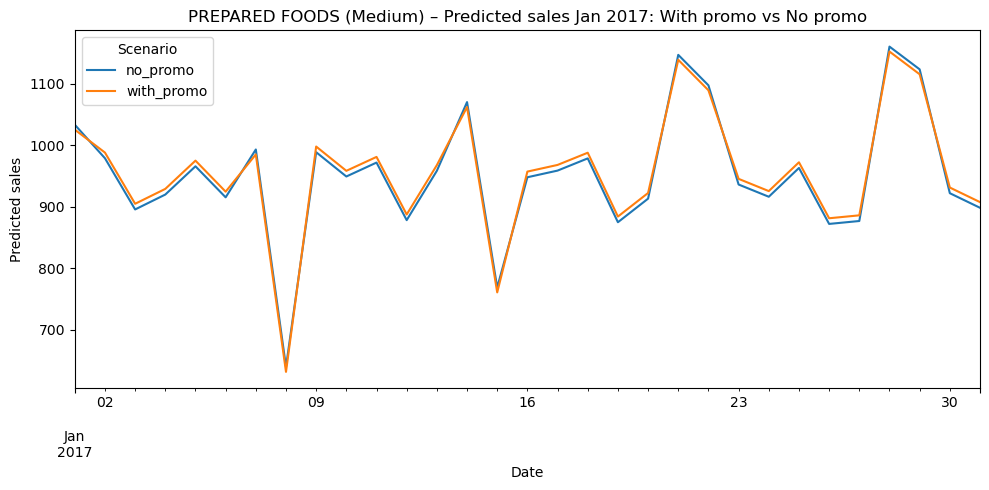

In [5]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ======================================================
# 1. Đọc dữ liệu promotion effect + segmentation
# ======================================================

# Dữ liệu đã prepare ở bước trước
df_pe = pd.read_csv("promotion_effect_train_data.csv", parse_dates=["date"])

# Đọc segmentation để biết family thuộc segment nào
seg_raw = pd.read_csv("family_segments.csv")
seg = seg_raw.copy()
seg.columns = [c.strip().lower() for c in seg.columns]

rename_map = {}
for c in seg.columns:
    if "family" in c and c != "family":
        rename_map[c] = "family"
    if "segment" in c and c != "segment":
        rename_map[c] = "segment"
seg = seg.rename(columns=rename_map)

# ==== CHỌN SEGMENT CẦN TEST ====
# Có thể là: "High", "Medium", "Low", "Ultra-low" (tuỳ file family_segments)
segment_name = "Medium"   # <<< ĐỔI Ở ĐÂY ĐỂ TEST SEGMENT KHÁC

families_in_segment = seg[seg["segment"] == segment_name]["family"].unique()
print(f"Families trong segment {segment_name}:", families_in_segment)

# ==== CHỌN 1 FAMILY TRONG SEGMENT ĐÃ CHỌN ====
family_name = "PREPARED FOODS"   # <<< ĐỔI TÊN FAMILY Ở ĐÂY

if family_name not in families_in_segment:
    raise ValueError(f"Family '{family_name}' không thuộc segment '{segment_name}' theo family_segments.csv")

# Lọc dữ liệu cho đúng family
df_fam = df_pe[df_pe["family"] == family_name].copy()
if df_fam.empty:
    raise ValueError(f"Không tìm thấy dữ liệu cho family = {family_name} trong promotion_effect_train_data.csv")

# ======================================================
# 2. Chuẩn bị feature & chia train / test (VD: tháng 1/2017)
# ======================================================

candidate_feature_cols = [
    "onpromotion",
    "promo_weekend",
    "promo_holiday",
    "is_weekend",
    "is_holiday",
    "day_of_week",
    "month",
    "dcoilwtico",
    "sales_lag_7",
    "sales_lag_14",
    "sales_lag_28",
    "rolling_mean_30",
    "transactions",
]

feature_cols = [c for c in candidate_feature_cols if c in df_fam.columns]
print("Features dùng cho model:", feature_cols)

y_col = "sales"

# Chia theo thời gian:
#   - train: trước 2017-01-01
#   - test: từ 2017-01-01 đến 2017-01-31 (tháng 1/2017)
train = df_fam[df_fam["date"] < "2017-01-01"].copy()
test_period = df_fam[
    (df_fam["date"] >= "2017-01-01") &
    (df_fam["date"] <= "2017-01-31")
].copy()

print("Train rows:", len(train), "– Test rows (Jan 2017):", len(test_period))
if len(train) < 50 or len(test_period) == 0:
    print("⚠️ Cảnh báo: train quá ít hoặc không có dữ liệu test – cần kiểm tra lại date range hoặc family.")

X_tr = train[feature_cols]
y_tr = train[y_col]

# Pipeline đơn giản: Imputer + LinearRegression
lr_family_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])

lr_family_pipe.fit(X_tr, y_tr)

# ======================================================
# 3. Kịch bản WITH PROMO (GIẢ ĐỊNH NGÀY NÀO CŨNG CÓ PROMO)
# ======================================================

test_with = test_period.copy()

# Giả định: ngày nào cũng có khuyến mãi
if "onpromotion" in test_with.columns:
    test_with["onpromotion"] = 1.0  # full promo

# Nếu có cột tương tác thì cho bằng is_weekend / is_holiday
if "promo_weekend" in test_with.columns and "is_weekend" in test_with.columns:
    test_with["promo_weekend"] = test_with["is_weekend"]

if "promo_holiday" in test_with.columns and "is_holiday" in test_with.columns:
    test_with["promo_holiday"] = test_with["is_holiday"]

X_test_with = test_with[feature_cols]
pred_with = lr_family_pipe.predict(X_test_with)

df_with = test_with[["date", "store_nbr", "family"]].copy()
df_with["sales_pred"] = pred_with
df_with["scenario"] = "with_promo"   # kịch bản full-promo


# ======================================================
# 4. Kịch bản NO PROMO (set onpromotion & interaction = 0)
# ======================================================

test_no = test_period.copy()
for col in ["onpromotion", "promo_weekend", "promo_holiday"]:
    if col in test_no.columns:
        test_no[col] = 0.0

X_test_no = test_no[feature_cols]
pred_no = lr_family_pipe.predict(X_test_no)

df_no = test_no[["date", "store_nbr", "family"]].copy()
df_no["sales_pred"] = pred_no
df_no["scenario"] = "no_promo"

# ======================================================
# 5. Lưu ra CSV: with / no promo / combined
# ======================================================

fam_safe = family_name.replace(" ", "_").replace("/", "_")

file_with = f"{fam_safe}_{segment_name}_2017Jan_with_promo.csv"
file_no = f"{fam_safe}_{segment_name}_2017Jan_no_promo.csv"
file_both = f"{fam_safe}_{segment_name}_2017Jan_with_vs_no_promo.csv"

df_with.to_csv(file_with, index=False)
df_no.to_csv(file_no, index=False)

df_both = pd.concat([df_with, df_no], ignore_index=True)
df_both = df_both.sort_values(["date", "scenario"])
df_both.to_csv(file_both, index=False)

print("Saved:")
print(" -", file_with)
print(" -", file_no)
print(" -", file_both)

# ======================================================
# 6. Vẽ biểu đồ đường so sánh (tùy chọn)
# ======================================================

daily = (
    df_both.groupby(["date", "scenario"])["sales_pred"]
           .sum()
           .reset_index()
)

pivot = daily.pivot(index="date", columns="scenario", values="sales_pred")

plt.figure(figsize=(10, 5))
pivot.plot(ax=plt.gca())
plt.title(f"{family_name} ({segment_name}) – Predicted sales Jan 2017: With promo vs No promo")
plt.xlabel("Date")
plt.ylabel("Predicted sales")
plt.legend(title="Scenario")
plt.tight_layout()
plt.show()




1. Bảng uplift tương đối (%) cho từng attribute

Từ promotion_effect_by_family.csv (đã có: family, coef_promo, coef_promo_weekend, coef_promo_holiday, mean_sale, segment)

Tính:

Uplift tuyệt đối:

uplift_normal_abs = coef_promo

uplift_weekend_abs = coef_promo + coef_promo_weekend

uplift_holiday_abs = coef_promo + coef_promo_holiday

Uplift tương đối (% so với mean_sale):

uplift_normal_pct = uplift_normal_abs / mean_sale * 100

uplift_weekend_pct = ...

uplift_holiday_pct = ...

Thêm uplift_max_pct = max của 3 cái trên để dùng xếp hạng.

In [20]:
import pandas as pd
import numpy as np

# Đọc bảng coef đã xuất
pe = pd.read_csv("promotion_effect_by_family.csv")

# Nếu file chưa có segment thì merge thêm
if "segment" not in pe.columns:
    seg_raw = pd.read_csv("family_segments.csv")
    seg = seg_raw.copy()
    seg.columns = [c.strip().lower() for c in seg.columns]
    rename_map = {}
    for c in seg.columns:
        if "family" in c and c != "family":
            rename_map[c] = "family"
        if "segment" in c and c != "segment":
            rename_map[c] = "segment"
    seg = seg.rename(columns=rename_map)
    seg = seg[["family", "segment"]]
    pe = pe.merge(seg, on="family", how="left")

# Tính uplift tuyệt đối
pe["uplift_normal_abs"]   = pe["coef_promo"]
pe["uplift_weekend_abs"]  = pe["coef_promo"] + pe["coef_promo_weekend"]
pe["uplift_holiday_abs"]  = pe["coef_promo"] + pe["coef_promo_holiday"]

# Tính uplift tương đối (%)
eps = 1e-9
pe["uplift_normal_pct"]  = 100 * pe["uplift_normal_abs"]  / (pe["mean_sale"] + eps)
pe["uplift_weekend_pct"] = 100 * pe["uplift_weekend_abs"] / (pe["mean_sale"] + eps)
pe["uplift_holiday_pct"] = 100 * pe["uplift_holiday_abs"] / (pe["mean_sale"] + eps)

# Uplift mạnh nhất trong 3 scenario
pe["uplift_max_pct"] = pe[[
    "uplift_normal_pct", "uplift_weekend_pct", "uplift_holiday_pct"
]].max(axis=1)

# Sắp xếp cho dễ đọc
cols = [
    "family", "segment", "mean_sale",
    "coef_promo", "coef_promo_weekend", "coef_promo_holiday",
    "uplift_normal_abs", "uplift_weekend_abs", "uplift_holiday_abs",
    "uplift_normal_pct", "uplift_weekend_pct", "uplift_holiday_pct",
    "uplift_max_pct"
]
pe_uplift = pe[cols].sort_values("uplift_max_pct", ascending=False).reset_index(drop=True)

# Xuất bảng uplift tương đối
pe_uplift.to_csv("promotion_effect_uplift_relative.csv", index=False)
print("Saved promotion_effect_uplift_relative.csv. Shape:", pe_uplift.shape)

# (tuỳ chọn) Uplift trung bình theo segment
seg_uplift = (
    pe_uplift
    .groupby("segment", as_index=False)[
        ["uplift_normal_pct", "uplift_weekend_pct", "uplift_holiday_pct", "uplift_max_pct"]
    ].mean()
)
seg_uplift.to_csv("promotion_effect_uplift_by_segment.csv", index=False)
print("Saved promotion_effect_uplift_by_segment.csv")
seg_uplift


Saved promotion_effect_uplift_relative.csv. Shape: (33, 13)
Saved promotion_effect_uplift_by_segment.csv


,segment,uplift_normal_pct,uplift_weekend_pct,uplift_holiday_pct,uplift_max_pct
0,High,0.852169,0.344436,1.306782,1.402128
1,Low,38.040874,54.369921,28.443622,67.404150
2,Medium,8.521183,6.831048,11.558963,15.846599
3,Ultra-low,220.546805,330.145477,52.039664,330.145477


2. Scatter: coef_promo vs mean_sale (colored by segment)

Code này dùng chính pe_uplift ở trên:

Nếu muốn scatter theo uplift% thay vì coef, đổi g["coef_promo"] thành g["uplift_normal_pct"].

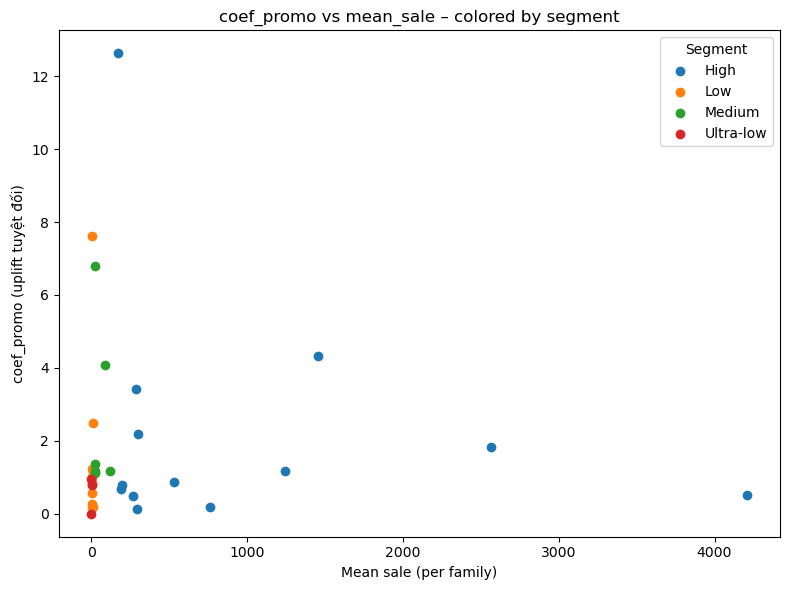

In [21]:
import matplotlib.pyplot as plt

# Scatter coef_promo vs mean_sale, tô màu theo segment
plt.figure(figsize=(8, 6))

for seg_name, g in pe_uplift.groupby("segment"):
    plt.scatter(g["mean_sale"], g["coef_promo"], label=seg_name)

plt.xlabel("Mean sale (per family)")
plt.ylabel("coef_promo (uplift tuyệt đối)")
plt.title("coef_promo vs mean_sale – colored by segment")
plt.legend(title="Segment")
plt.tight_layout()
plt.show()


3. Bar chart top promo-sensitive families

Dùng uplift_max_pct để xếp hạng:

Nếu muốn chia theo segment (màu khác nhau), có thể tự thêm mapping màu theo top["segment"].

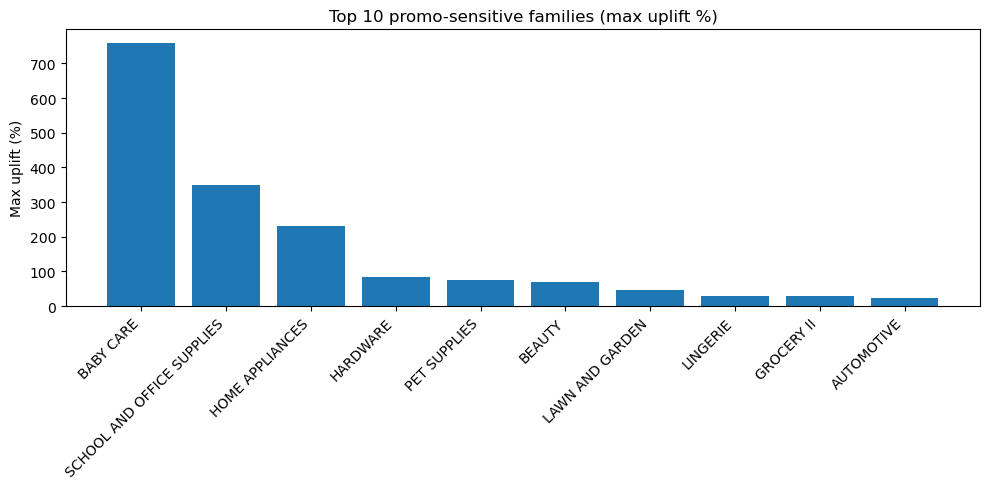

In [22]:
# Lấy top 10 family nhạy với promotion nhất (theo uplift_max_pct)
topN = 10
top = pe_uplift.head(topN)

plt.figure(figsize=(10, 5))
plt.bar(top["family"], top["uplift_max_pct"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Max uplift (%)")
plt.title(f"Top {topN} promo-sensitive families (max uplift %)")
plt.tight_layout()
plt.show()


4. Bar / Heatmap tần suất feature (từ LASSO)

4.1 Bảng tần suất feature (tổng thể)

In [23]:
# Đọc lasso_selected_features
lf = pd.read_csv("lasso_selected_features.csv")

# Thêm segment cho từng family
seg_raw = pd.read_csv("family_segments.csv")
seg = seg_raw.copy()
seg.columns = [c.strip().lower() for c in seg.columns]
rename_map = {}
for c in seg.columns:
    if "family" in c and c != "family":
        rename_map[c] = "family"
    if "segment" in c and c != "segment":
        rename_map[c] = "segment"
seg = seg.rename(columns=rename_map)
seg = seg[["family", "segment"]]

lf = lf.merge(seg, on="family", how="left")

# Tần suất mỗi feature xuất hiện trong bao nhiêu family
freq = (
    lf.groupby("feature")["family"]
      .nunique()
      .reset_index(name="n_families")
      .sort_values("n_families", ascending=False)
)

n_total_fam = seg["family"].nunique()
freq["pct_families"] = 100 * freq["n_families"] / n_total_fam

freq.to_csv("lasso_feature_frequency_overall.csv", index=False)
print("Saved lasso_feature_frequency_overall.csv")
freq.head(10)


Saved lasso_feature_frequency_overall.csv


,feature,n_families,pct_families
8,rolling_mean_30,33,100.000000
10,sales_lag_7,33,100.000000
9,sales_lag_14,32,96.969697
5,onpromotion,32,96.969697
3,is_weekend,31,93.939394
4,month,29,87.878788
2,is_holiday,27,81.818182
7,promo_weekend,27,81.818182
1,dcoilwtico,26,78.787879
11,transactions,24,72.727273


4.2 Heatmap feature × segment

Nếu heatmap quá dài, có thể lọc top feature trước:

"top_feat = freq.head(15)["feature"]
pivot_small = pivot.loc[pivot.index.isin(top_feat)]
# rồi vẽ lại với pivot_small"

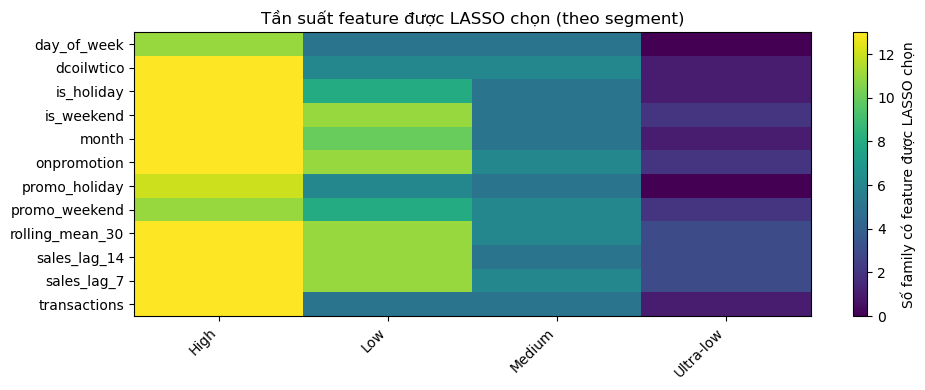

In [24]:
# Bảng số family mà feature xuất hiện theo từng segment
tab = (
    lf.groupby(["feature", "segment"])["family"]
      .nunique()
      .reset_index(name="n_families")
)

pivot = tab.pivot(index="feature", columns="segment", values="n_families").fillna(0)

plt.figure(figsize=(10, max(4, len(pivot) * 0.3)))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Số family có feature được LASSO chọn")

plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")

plt.title("Tần suất feature được LASSO chọn (theo segment)")
plt.tight_layout()
plt.show()


5. 1–2 plot baseline vs actual với highlight promo

Ở đây dùng promotion_effect_train_data.csv để:

Chọn 1 family & đoạn thời gian (VD: Jan 2017),

Fit Linear Regression per-family,

Vẽ:

Actual sales (đường thật),

Baseline (no_promo) dựa trên model,

Highlight ngày có promotion.

chỉ cần đổi:

family_name

start_date, end_date

BEVERAGES: train=11656, test=248


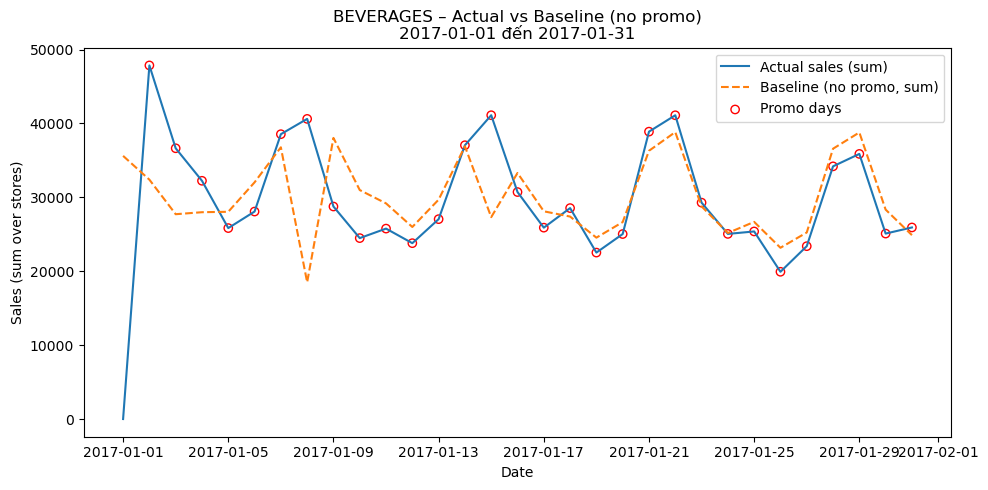

In [25]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df_pe = pd.read_csv("promotion_effect_train_data.csv", parse_dates=["date"])

candidate_feature_cols = [
    "onpromotion",
    "promo_weekend",
    "promo_holiday",
    "is_weekend",
    "is_holiday",
    "day_of_week",
    "month",
    "dcoilwtico",
    "sales_lag_7",
    "sales_lag_14",
    "sales_lag_28",
    "rolling_mean_30",
    "transactions",
]
feature_cols = [c for c in candidate_feature_cols if c in df_pe.columns]
y_col = "sales"

def plot_baseline_vs_actual(family_name, start_date="2017-01-01", end_date="2017-01-31"):
    df_fam = df_pe[df_pe["family"] == family_name].copy()
    if df_fam.empty:
        print(f"Không có dữ liệu cho family = {family_name}")
        return
    
    # Chia train / test theo thời gian
    train = df_fam[df_fam["date"] < start_date].copy()
    test_period = df_fam[
        (df_fam["date"] >= start_date) &
        (df_fam["date"] <= end_date)
    ].copy()
    
    print(f"{family_name}: train={len(train)}, test={len(test_period)}")
    if len(train) < 50 or len(test_period) == 0:
        print("⚠️ Quá ít dữ liệu cho giai đoạn này")
        return
    
    X_tr = train[feature_cols]
    y_tr = train[y_col]
    
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression())
    ])
    pipe.fit(X_tr, y_tr)
    
    # --- Baseline no-promo ---
    base = test_period.copy()
    for col in ["onpromotion", "promo_weekend", "promo_holiday"]:
        if col in base.columns:
            base[col] = 0.0
    X_base = base[feature_cols]
    y_base_pred = pipe.predict(X_base)
    
    # --- Chuẩn bị dữ liệu để gộp theo ngày ---
    df_plot = test_period[["date"]].copy()
    df_plot["actual"] = test_period[y_col].values
    df_plot["baseline"] = y_base_pred
    df_plot["promo_flag"] = test_period["onpromotion"] > 0  # có promo ở bất kỳ store nào
    
    # Gộp theo ngày (tổng doanh số)
    daily = (
        df_plot.groupby("date", as_index=False)
               .agg(actual=("actual", "sum"),
                    baseline=("baseline", "sum"),
                    promo_flag=("promo_flag", "max"))
    )
    
    dates = daily["date"].values
    y_actual_day = daily["actual"].values
    y_base_day = daily["baseline"].values
    promo_mask = daily["promo_flag"].values
    
    # --- Vẽ ---
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_actual_day, label="Actual sales (sum)")
    plt.plot(dates, y_base_day, "--", label="Baseline (no promo, sum)")
    
    # highlight ngày có promo
    if promo_mask.any():
        plt.scatter(dates[promo_mask], y_actual_day[promo_mask],
                    facecolors="none", edgecolors="red", label="Promo days")
    
    plt.title(f"{family_name} – Actual vs Baseline (no promo)\n{start_date} đến {end_date}")
    plt.xlabel("Date")
    plt.ylabel("Sales (sum over stores)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Ví dụ gọi cho 1–2 family:
plot_baseline_vs_actual("BEVERAGES", start_date="2017-01-01", end_date="2017-01-31")
# plot_baseline_vs_actual("SCHOOL AND OFFICE SUPPLIES", start_date="2017-01-01", end_date="2017-01-31")


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================================================
# 0. LOAD DATA + SEGMENT
# ======================================================
df = pd.read_csv("train_data.csv", parse_dates=["date"])

# family_segments
seg_raw = pd.read_csv("family_segments.csv")
seg = seg_raw.copy()
seg.columns = [c.strip().lower() for c in seg.columns]

rename_map = {}
for c in seg.columns:
    if "family" in c and c != "family":
        rename_map[c] = "family"
    if "segment" in c and c != "segment":
        rename_map[c] = "segment"
seg = seg.rename(columns=rename_map)

seg = seg[["family", "segment"]]
df = df.merge(seg, on="family", how="left")   # thêm cột segment vào train_data

# promotion_effect_by_family (coef + mean_sale)
pe = pd.read_csv("promotion_effect_by_family.csv")
if "segment" not in pe.columns:
    pe = pe.merge(seg, on="family", how="left")


In [27]:
# ======================================================
# TABLE 6.4: avg_sales_nonpromo, avg_sales_promo, uplift
# ======================================================
df["is_promo"] = (df["onpromotion"] > 0).astype(int)

tbl = (df
       .groupby(["family", "segment", "is_promo"])["sales"]
       .mean()
       .unstack("is_promo")
       .rename(columns={0: "avg_sales_nonpromo", 1: "avg_sales_promo"})
       .reset_index())

# tính uplift tương đối
tbl["uplift_rel"] = (tbl["avg_sales_promo"] - tbl["avg_sales_nonpromo"]) / tbl["avg_sales_nonpromo"]

# lưu để nhóm dùng
tbl.to_csv("table_promo_vs_nonpromo_by_family.csv", index=False)
print(tbl.head())


is_promo      family    segment  avg_sales_nonpromo  avg_sales_promo  \
0         AUTOMOTIVE        Low            6.409137        13.762183   
1          BABY CARE  Ultra-low            0.178247         1.633333   
2             BEAUTY        Low            3.141598         7.587933   
3          BEVERAGES       High         1549.306679      3254.747971   
4              BOOKS  Ultra-low            0.074970              NaN   

is_promo  uplift_rel  
0           1.147276  
1           8.163300  
2           1.415310  
3           1.100777  
4                NaN  


Figure 6.1 – Top families by total sales

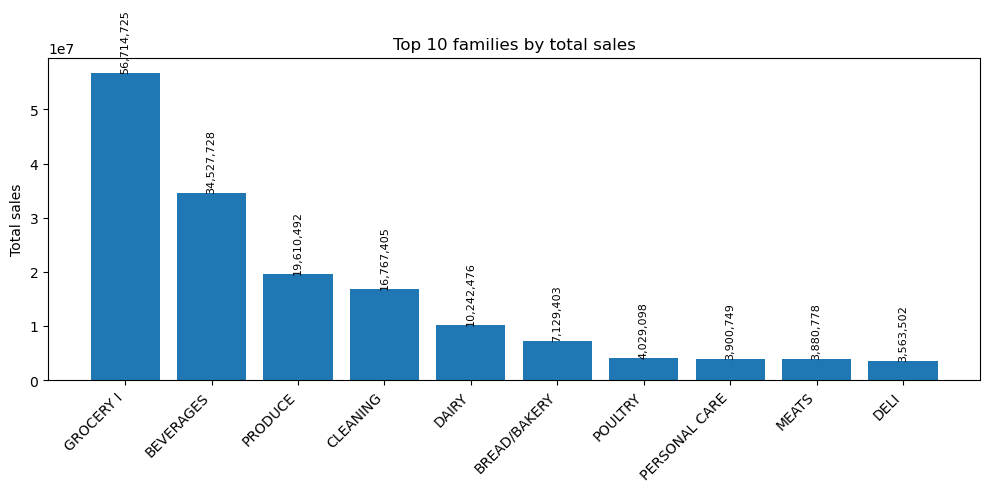

In [36]:
# ==== FIGURE 6.1: Top families by total sales ====
top_k = 10  # muốn top 20 thì đổi số này

fam_sales = (
    df.groupby("family")["sales"]
      .sum()
      .reset_index(name="total_sales")
      .merge(seg, on="family", how="left")
      .sort_values("total_sales", ascending=False)
      .head(top_k)
)

plt.figure(figsize=(10, 5))
x = np.arange(len(fam_sales))

bars = plt.bar(x, fam_sales["total_sales"])
plt.xticks(x, fam_sales["family"], rotation=45, ha="right")
plt.ylabel("Total sales")
plt.title(f"Top {top_k} families by total sales")

# ghi số lên trên cột
for xi, yi in zip(x, fam_sales["total_sales"]):
    plt.text(xi, yi, f"{yi:,.0f}", ha="center", va="bottom", fontsize=8, rotation=90)

plt.tight_layout()
plt.show()


Figure 6.3 – Promotion elasticity by family

(x-axis = mean_sale, y-axis = promo uplift %)

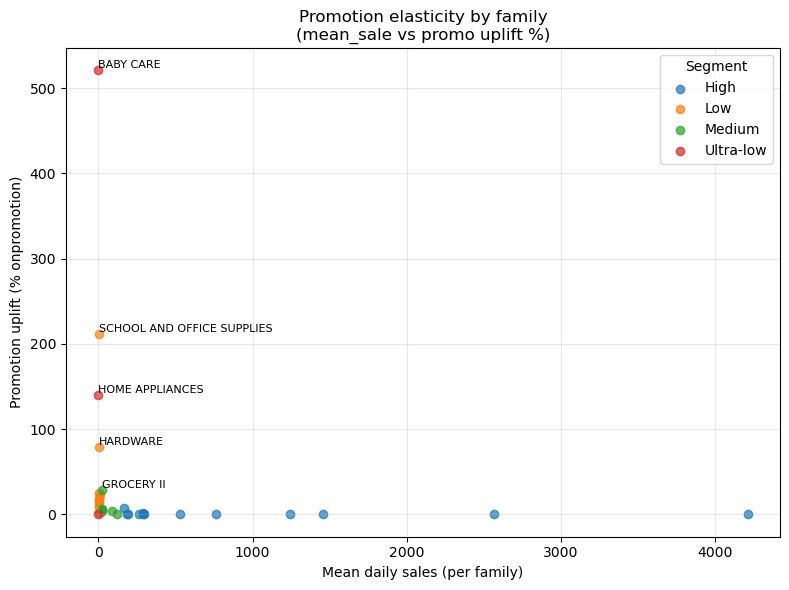

In [37]:
# ==== FIGURE 6.3: Promotion elasticity by family ====

# Nếu file chưa có cột uplift_pct thì tự tính
if "promo_uplift_pct" not in promo.columns:
    promo = promo.copy()
    promo["promo_uplift_pct"] = promo["coef_promo"] / promo["mean_sale"] * 100

plt.figure(figsize=(8, 6))

for seg_name, g in promo.groupby("segment"):
    plt.scatter(
        g["mean_sale"],
        g["promo_uplift_pct"],
        label=seg_name,
        alpha=0.7
    )

plt.xlabel("Mean daily sales (per family)")
plt.ylabel("Promotion uplift (% onpromotion)")
plt.title("Promotion elasticity by family\n(mean_sale vs promo uplift %)")

# highlight vài family nhạy promo nhất
top_uplift = promo.nlargest(5, "promo_uplift_pct")
for _, row in top_uplift.iterrows():
    plt.text(row["mean_sale"], row["promo_uplift_pct"],
             row["family"], fontsize=8, ha="left", va="bottom")

plt.legend(title="Segment")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Figure 6.4 – Sales heatmap by cluster (có thể đổi sang city)

Ở đây mình vẽ cluster × month; nếu muốn theo city chỉ cần đổi cộ

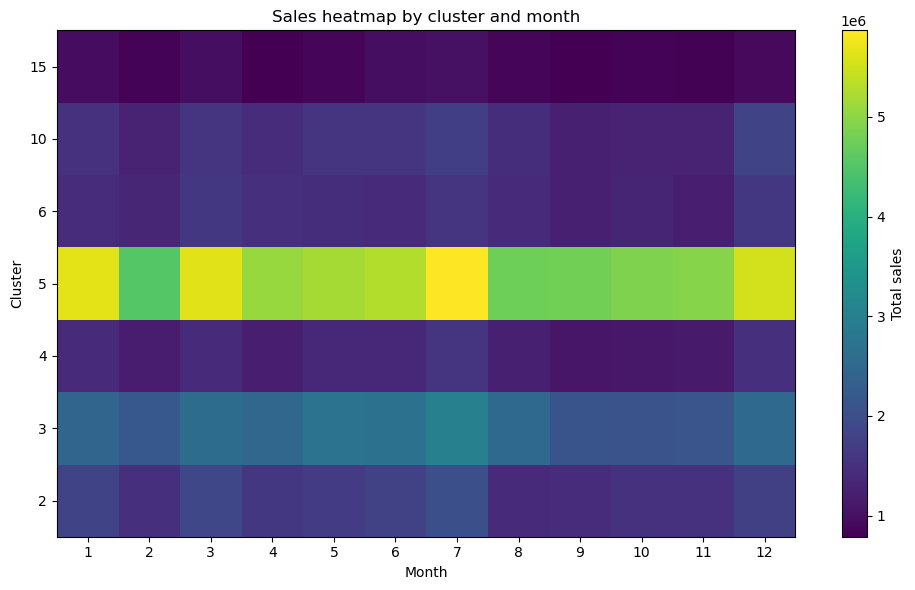

In [38]:
# ==== FIGURE 6.4: Sales heatmap by cluster & month ====

# đảm bảo có cột month (nếu train_data đã feature engineer thì có sẵn)
if "month" not in df.columns:
    df["month"] = df["date"].dt.month

heat = (
    df.groupby(["cluster", "month"])["sales"]
      .sum()
      .reset_index()
      .pivot(index="cluster", columns="month", values="sales")
      .fillna(0)
)

plt.figure(figsize=(10, 6))
im = plt.imshow(heat.values, aspect="auto", origin="lower")

plt.xticks(
    ticks=np.arange(len(heat.columns)),
    labels=heat.columns
)
plt.yticks(
    ticks=np.arange(len(heat.index)),
    labels=heat.index
)

plt.xlabel("Month")
plt.ylabel("Cluster")
plt.title("Sales heatmap by cluster and month")
cbar = plt.colorbar(im)
cbar.set_label("Total sales")

plt.tight_layout()
plt.show()

# Gợi ý: muốn heatmap theo city thì dùng:
# heat_city = df.groupby(["city","month"])["sales"].sum().reset_index().pivot("city","month","sales")


Figure 6.5 – Oil price vs sales in sensitive vs non-sensitive clusters

Ý tưởng:

Tính tương quan giữa dầu (dcoilwtico) và daily sales cho từng cluster.

Chọn vài cluster tương quan mạnh nhất làm “sensitive”, vài cluster tương quan gần 0 làm “non-sensitive”.

Vẽ scatter oil vs sales cho 2 nhóm để so sánh.

Sensitive clusters: [3, 10, 2]
Non-sensitive clusters: [4, 6, 15]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2216\3390793057.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["sales"].corr(g["dcoilwtico"]))


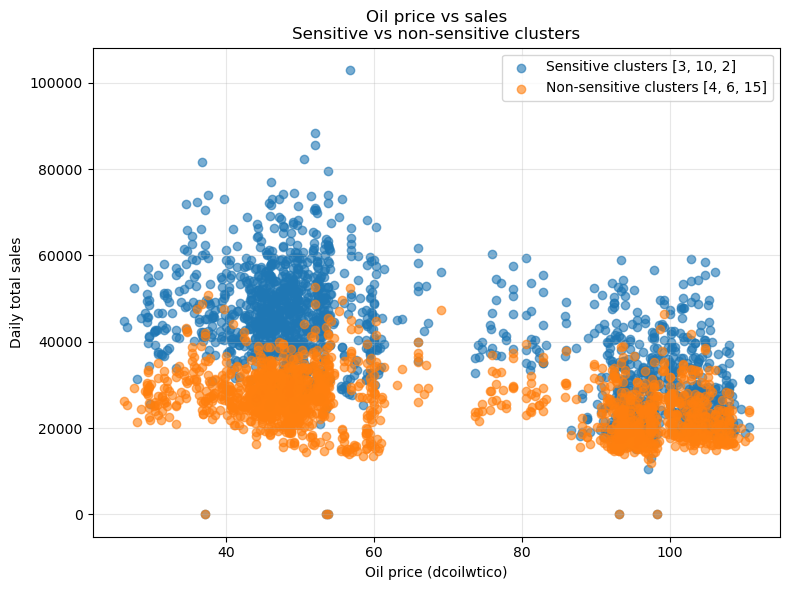

: 

In [ ]:
# ==== FIGURE 6.5: Oil price vs sales in sensitive vs non-sensitive clusters ====

# 1) Daily sales + oil price per cluster
daily_cluster = (
    df.groupby(["date", "cluster"])
      .agg(sales=("sales", "sum"),
           dcoilwtico=("dcoilwtico", "mean"))
      .reset_index()
      .dropna(subset=["dcoilwtico"])
)

# 2) Corr(sales, oil) cho từng cluster
corr_tbl = (
    daily_cluster.groupby("cluster")
      .apply(lambda g: g["sales"].corr(g["dcoilwtico"]))
      .reset_index(name="corr_sales_oil")
      .dropna()
)

# chọn 3 cluster nhạy nhất và 3 cluster ít nhạy nhất
n_pick = 3
sens_clusters = (corr_tbl
                 .reindex(corr_tbl["corr_sales_oil"].abs().sort_values(ascending=False).index)
                 .head(n_pick)["cluster"]
                 .tolist())

nonsens_clusters = (corr_tbl
                    .reindex(corr_tbl["corr_sales_oil"].abs().sort_values(ascending=True).index)
                    .head(n_pick)["cluster"]
                    .tolist())

print("Sensitive clusters:", sens_clusters)
print("Non-sensitive clusters:", nonsens_clusters)

# 3) Daily series cho 2 group
sens = (
    daily_cluster[daily_cluster["cluster"].isin(sens_clusters)]
      .groupby("date")
      .agg(sales=("sales", "sum"),
           dcoilwtico=("dcoilwtico", "mean"))
      .reset_index()
)

nonsens = (
    daily_cluster[daily_cluster["cluster"].isin(nonsens_clusters)]
      .groupby("date")
      .agg(sales=("sales", "sum"),
           dcoilwtico=("dcoilwtico", "mean"))
      .reset_index()
)

# 4) Scatter oil vs sales cho 2 nhóm
plt.figure(figsize=(8, 6))
plt.scatter(sens["dcoilwtico"], sens["sales"],
            alpha=0.6, label=f"Sensitive clusters {sens_clusters}")
plt.scatter(nonsens["dcoilwtico"], nonsens["sales"],
            alpha=0.6, label=f"Non-sensitive clusters {nonsens_clusters}")

plt.xlabel("Oil price (dcoilwtico)")
plt.ylabel("Daily total sales")
plt.title("Oil price vs sales\nSensitive vs non-sensitive clusters")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
